# Building a Neural Network from Scratch

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

### Abstract Base Class : Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [28]:

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError 

In the abstract class above, backward_propagation function has an extra parameter, learning_rate, which is controlling the amount of learning/updating parameters using gradient descent.

### Backward Propagation
Suppose we have a matrix containing the derivative of the error with respect to that layer’s output: $\frac{\partial E}{\partial Y}$

We need :
- The derivative of the error with respect to the parameters ($\frac{\partial E}{\partial W}$, $\frac{\partial E}{\partial B}$)
- The derivative of the error with respect to the input ($\frac{\partial E}{\partial X}$)

Let's calculate $\frac{\partial E}{\partial W}$. This matrix should be the same size as $W$ itself : 

$i x j$ where $i$ is the number of input neurons and $j$ the number of output neurons. We need one gradient for every weight

### Coding the Fully Connected Layer

In [29]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer
All the calculation we did until now were completely linear, may not learn well. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

In [30]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [31]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

def sig(x):
    return 1/(1 + np.exp(-x))

def sig_prime(x):
    return  sig(x) * (1-sig(x))

def relu(x):
  if x.any()>0 :
    return x
  else :
    return  0 
def reluprime(x):
    return np.where(x > 0, 1.0, 0.0)

### Loss Function
Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.
The error of the network, which measures how good or bad the network did for a given input data, is defined by you. 

There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

In [32]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Network Class
Almost done ! We are going to make a Network class to create neural networks very easily using the building blocks we have prepared so far.


In [33]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [34]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks
Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.


### Solve XOR
Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [40]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

epoch 1/1000   error=0.620474
epoch 2/1000   error=0.350066
epoch 3/1000   error=0.306944
epoch 4/1000   error=0.297308
epoch 5/1000   error=0.294176
epoch 6/1000   error=0.292838
epoch 7/1000   error=0.292125
epoch 8/1000   error=0.291673
epoch 9/1000   error=0.291346
epoch 10/1000   error=0.291084
epoch 11/1000   error=0.290863
epoch 12/1000   error=0.290666
epoch 13/1000   error=0.290487
epoch 14/1000   error=0.290321
epoch 15/1000   error=0.290165
epoch 16/1000   error=0.290019
epoch 17/1000   error=0.289879
epoch 18/1000   error=0.289747
epoch 19/1000   error=0.289620
epoch 20/1000   error=0.289499
epoch 21/1000   error=0.289383
epoch 22/1000   error=0.289272
epoch 23/1000   error=0.289165
epoch 24/1000   error=0.289062
epoch 25/1000   error=0.288963
epoch 26/1000   error=0.288868
epoch 27/1000   error=0.288776
epoch 28/1000   error=0.288688
epoch 29/1000   error=0.288602
epoch 30/1000   error=0.288519
epoch 31/1000   error=0.288439
epoch 32/1000   error=0.288361
epoch 33/1000   e

In [41]:
# network
net1 = Network()
net1.add(FCLayer(2, 3))
net1.add(ActivationLayer(sig, sig_prime))
net1.add(FCLayer(3, 1))
net1.add(ActivationLayer(sig, sig_prime))

# train
net1.use(mse, mse_prime)
net1.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net1.predict(x_train)
print(out)

epoch 1/1000   error=0.256119
epoch 2/1000   error=0.256026
epoch 3/1000   error=0.255947
epoch 4/1000   error=0.255881
epoch 5/1000   error=0.255825
epoch 6/1000   error=0.255778
epoch 7/1000   error=0.255738
epoch 8/1000   error=0.255705
epoch 9/1000   error=0.255676
epoch 10/1000   error=0.255652
epoch 11/1000   error=0.255632
epoch 12/1000   error=0.255615
epoch 13/1000   error=0.255600
epoch 14/1000   error=0.255587
epoch 15/1000   error=0.255576
epoch 16/1000   error=0.255567
epoch 17/1000   error=0.255559
epoch 18/1000   error=0.255552
epoch 19/1000   error=0.255546
epoch 20/1000   error=0.255541
epoch 21/1000   error=0.255537
epoch 22/1000   error=0.255533
epoch 23/1000   error=0.255529
epoch 24/1000   error=0.255526
epoch 25/1000   error=0.255523
epoch 26/1000   error=0.255520
epoch 27/1000   error=0.255518
epoch 28/1000   error=0.255516
epoch 29/1000   error=0.255514
epoch 30/1000   error=0.255512
epoch 31/1000   error=0.255510
epoch 32/1000   error=0.255509
epoch 33/1000   e

In [36]:
net2 = Network()
net2.add(FCLayer(2, 3))
net2.add(ActivationLayer(relu, reluprime))
net2.add(FCLayer(3, 1))
net2.add(ActivationLayer(relu, reluprime))

# train
net2.use(mse, mse_prime)
net2.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net2.predict(x_train)
print(out)

epoch 1/1000   error=0.397868
epoch 2/1000   error=0.362480
epoch 3/1000   error=0.360049
epoch 4/1000   error=0.343062
epoch 5/1000   error=0.337952
epoch 6/1000   error=0.334928
epoch 7/1000   error=0.331173
epoch 8/1000   error=0.332962
epoch 9/1000   error=0.326846
epoch 10/1000   error=0.324778
epoch 11/1000   error=0.326007
epoch 12/1000   error=0.322518
epoch 13/1000   error=0.321137
epoch 14/1000   error=0.320782
epoch 15/1000   error=0.320582
epoch 16/1000   error=0.318838
epoch 17/1000   error=0.318766
epoch 18/1000   error=0.317976
epoch 19/1000   error=0.317243
epoch 20/1000   error=0.317565
epoch 21/1000   error=0.316800
epoch 22/1000   error=0.316237
epoch 23/1000   error=0.316383
epoch 24/1000   error=0.315911
epoch 25/1000   error=0.315455
epoch 26/1000   error=0.315644
epoch 27/1000   error=0.315231
epoch 28/1000   error=0.315443
epoch 29/1000   error=0.315086
epoch 30/1000   error=0.314745
epoch 31/1000   error=0.314980
epoch 32/1000   error=0.314684
epoch 33/1000   e

### Solve MNIST
We didn’t implemented the Convolutional Layer but this is not a problem. 
All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.
MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. 
The goal is to predict what digit is drawn on a picture.

In [37]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35   error=0.230505
epoch 2/35   error=0.104986
epoch 3/35   error=0.083177
epoch 4/35   error=0.069383
epoch 5/35   error=0.058646
epoch 6/35   error=0.050248
epoch 7/35   error=0.042921
epoch 8/35   error=0.037070
epoch 9/35   error=0.032976
epoch 10/35   error=0.029578
epoch 11/35   error=0.026702
epoch 12/35   error=0.024298
epoch 13/35   error=0.022419
epoch 14/35   error=0.020693
epoch 15/35   error=0.019296
epoch 16/35   error=0.018135
epoch 17/35   error=0.016745
epoch 18/35   error=0.015564
epoch 19/35   error=0.014598
epoch 20/35   error=0.013772
epoch 21/35   error=0.013070
epoch 22/35   error=0.012338
epoch 23/35   error=0.011780
epoch 24/35   error=0.011329
epoch 25/35   error=0.010885
epoch 26/35   error=0.010489
epoch 27/35   error=0.010112
epoch 28/35   error=0.009871
epoch 29/35   error=0.009565
epoch 30/35   error=0.009314
epoch 31/35   error=0.009057
epoch 32/35   error=0.008805
epoch 33/35   error=0.008625
epoch 34/35   error=0.008373
epoch 35/35   error=0.0

In [38]:
print(x_test[0:3])

[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]


In [44]:
import pandas as pd
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


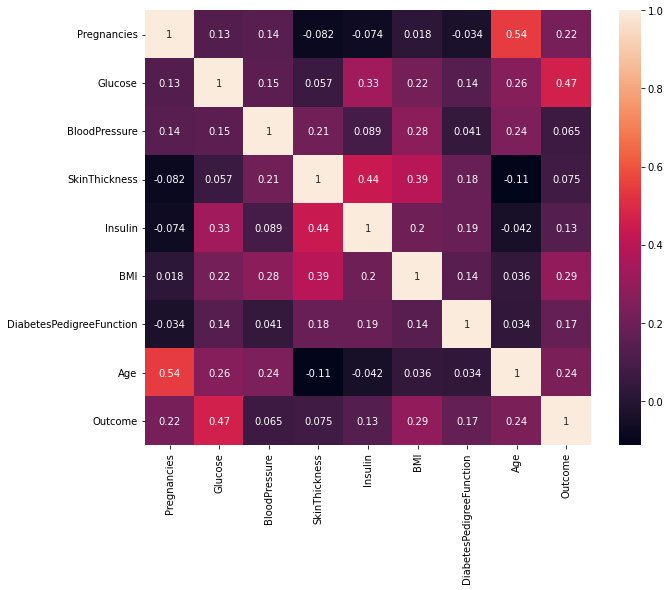

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10,8))
sns.heatmap(diabetes_df.corr(), annot=True, ax=ax)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X = diabetes_df.drop('Outcome', axis =1).values
y = diabetes_df.Outcome.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
nl = Normalizer()
nl.fit(X_train)
X_train = nl.transform(X_train)
X_test = nl.transform(X_test)
print(X_train.shape)


(537, 8)


In [55]:
net3 = Network()
net3.add(FCLayer(8, 20))
net3.add(ActivationLayer(relu, reluprime))
net3.add(FCLayer(20, 10))
net3.add(ActivationLayer(relu, reluprime))
net3.add(FCLayer(10, 2))
net3.add(ActivationLayer(relu, reluprime))

# train
net3.use(mse, mse_prime)
net3.fit(X_train, y_train, epochs=35, learning_rate=0.1)

net3.use(mse, mse_prime)
net3.fit(X_train, y_train, epochs=35, learning_rate=0.1)

out = net3.predict(X_test)
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test)

ValueError: ignored